In [1]:
# FOR MASK RCNN / COCO -----------------------------------------
# run this - needed for the Coco Dataset 
# pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
# repo for it: https://github.com/philferriere/cocoapi
 
# http://cocodataset.org/#download
# from above, download 2017 Train/Val annotations
# 2017 Val images
# put it in a folder named 'data' or edit dataset cell (last one w/code) 

import torch
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader

from pycocotools.coco import COCO

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline

# Gets the GPU if there is one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mask R-CNN

In [2]:
# https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
#network = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
network.eval();

In [3]:
coco_val = torchvision.datasets.CocoDetection("data/val2017", annFile="data/annotations/instances_val2017.json",
                                             transform=transforms.ToTensor())

labels = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
] # list of labels 
len(labels)

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!


91

In [4]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# haven't really looked at that much yet. might help a lot

In [5]:
# Look at sizes
for i in range(10):
    print(coco_val[i][0].shape)
#coco_val[0][0] # 0th instance, 0 = image (1 = segmentation)

torch.Size([3, 426, 640])
torch.Size([3, 640, 586])
torch.Size([3, 483, 640])
torch.Size([3, 500, 375])
torch.Size([3, 640, 428])
torch.Size([3, 425, 640])
torch.Size([3, 640, 424])
torch.Size([3, 640, 621])
torch.Size([3, 427, 640])
torch.Size([3, 480, 640])


In [38]:
j = 1 # which image
image = coco_val[j][0].unsqueeze(0).to(device)
with torch.no_grad(): # to help keep CUDA memory free
    output = network(image)[0]
print(output.keys())
print("number of boxes/labels", len(output['labels']))

#output['boxes'][:5]

dict_keys(['boxes', 'labels', 'scores', 'masks'])
number of boxes/labels 1


# of Boxes:  1
Box #0 :  bear 99.4252% ,  336404.4375


{'bear'}

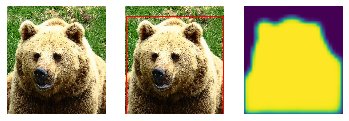

In [39]:
# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()

fig = plt.figure()

# just image
plt.subplot(1, 3, 1)
plt.imshow(to_plot_image)
plt.axis('off')

# image & boxes
plt.subplot(1, 3, 2)
plt.imshow(to_plot_image)
plt.axis('off')
label_list = []
print('# of Boxes: ', len(output['boxes']))
for i in range(len(output['boxes'])): # go through each box
    width = output['boxes'][i][2] - output['boxes'][i][0]
    height = output['boxes'][i][3] - output['boxes'][i][1]
    #if height < 10 or width < 10: continue
    # add a rectangle ((x,y), w, h)
    fig.get_axes()[1].add_patch(matplotlib.patches.Rectangle((output['boxes'][i][0], output['boxes'][i][1]), 
                                width, height, fill=False, color='r', linewidth=1))
    label_list.append(labels[output['labels'][i].item()])
    print('Box #'+ str(i), ": ", labels[output['labels'][i].item()], "{:.4f}".format(scores[i].item()*100)+"%", ", ", (width*height).item()) # print label of box

# just first mask
plt.subplot(1, 3, 3)
plt.imshow(output['masks'][0].cpu().squeeze())
plt.axis('off')

set(label_list) # all different labels

In [14]:
mask = output['masks'][0].cpu().squeeze()
df = pd.DataFrame(mask.numpy())